In [1]:
# Standard Libraries
import numpy as np
import pandas as pd

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, accuracy_score
import optuna

# TensorFlow Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape, RepeatVector, TimeDistributed, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Keras Tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import math
import numpy as np
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from kerastuner import HyperModel, Hyperband
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed, Flatten, BatchNormalization, Reshape, Dropout
import pandas as pd

/var/folders/q4/c1myh43d3jxcdphy8t47cdqm0000gn/T/ipykernel_26024/2580772081.py:42: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


In [2]:
df=pd.read_csv('../data/BitcoinHeistDataPreProcessed.csv')

# The following is tuned result of feature selection

In [3]:
# #ALL
# selected_features = ['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
#        'neighbors', 'income', 'n_address_feature', 'quarter_number',
#        'is_close_to_holiday', 'day_of_week', 'average_income_per_transaction',
#        'transaction_count', 'looped_ratio', 'merge_behavior',
#        'cybercrime_related', 'length_weight', 'count_looped', 'month', 'week',
#        'total_volume', 'average_volume', 'transaction_frequency', 'cluster']

In [4]:
#Montreal
selected_features = ['address', 'year', 'day', 'length', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'merge_behavior', 'length_weight', 'week',
       'total_volume', 'average_volume', 'transaction_frequency']

In [5]:
# #Padua
# selected_features = ['address', 'year', 'day', 'neighbors', 'income', 'n_address_feature',
#        'day_of_week', 'average_income_per_transaction', 'transaction_count',
#        'merge_behavior', 'week', 'total_volume', 'average_volume',
#        'transaction_frequency']

In [6]:
# # Princeton
# selected_features = ['address', 'year', 'day', 'length', 'weight', 'neighbors', 'income',
#        'n_address_feature', 'day_of_week', 'average_income_per_transaction',
#        'transaction_count', 'looped_ratio', 'total_volume', 'average_volume',
#        'transaction_frequency']


# Version1 Only take designated attack as simulated attack

In [7]:
# The label Montreal is encoded as 0
# The label Panuda is encoded as 1
# The label Princeton is encoded as 2
# The label White is encoded as 3

# df1: designated attack (1)
# df2: other attacks (1)
# df3: white (0)

# Variable for designated attack
designated_attack = 0

# df1: designated attack (1)
df1 = df[df['label'] == designated_attack][selected_features + ['label']].copy()
df1['label'] = 1  # Transfer its original label to 1

# df2: white (0)
df2 = df[df['label'] == 3][selected_features + ['label']].copy()
df2['label'] = 0

# Shuffle df2
df2 = df2.sample(frac=1, random_state=1)
df2.reset_index(drop=True, inplace=True)  # Reset the index after shuffling

# Calculate the counts
total_normal = df2.shape[0]  
total_attack = df1.shape[0]  

# Define the splits
train_normal_count = int(0.60 * total_normal)  
test_and_val_normal_count = int(0.50 * total_attack)  

# Split the data
df_train = df2[:train_normal_count]  
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
y_train = y_train.reset_index(drop=True)

df_test_normal = df2[train_normal_count : train_normal_count + test_and_val_normal_count]  
df_test_attack = df1[:test_and_val_normal_count]
df_test = pd.concat([df_test_normal, df_test_attack])
X_test = df_test.drop('label', axis=1)
y_test = df_test['label']
y_test = y_test.reset_index(drop=True)

df_val_mixed_normal = df2[train_normal_count + test_and_val_normal_count : train_normal_count + 2 * test_and_val_normal_count]
df_val_mixed_attack = df1[test_and_val_normal_count:]
df_val_mixed = pd.concat([df_val_mixed_normal, df_val_mixed_attack])
X_validation_mixed = df_val_mixed.drop('label', axis=1)
y_validation_mixed = df_val_mixed['label']
y_validation_mixed = y_validation_mixed.reset_index(drop=True)

df_val_normal = df2[train_normal_count + 2 * test_and_val_normal_count:]  
X_validation_normal = df_val_normal.drop('label', axis=1)
y_validation_normal = df_val_normal['label']
y_validation_normal = y_validation_normal.reset_index(drop=True)

# Converting the dataframes to numpy arrays and ensuring they're float32
X_train = np.asarray(X_train).astype(np.float32)
X_validation_normal = np.asarray(X_validation_normal).astype(np.float32)
X_validation_mixed = np.asarray(X_validation_mixed).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)


# Feature Selection

In [ ]:
# Feature selection
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)  # Fit on the training data

# Print the feature names before selection
original_feature_names = X_train.columns  # Get feature names from the training data
print('Original features: {}'.format(original_feature_names))

# Get feature importances
importances = gb.feature_importances_

# Create a boolean mask of features selected by the model
mask = importances > 0.001  # adjust threshold as needed

# Apply the mask to the feature dataset
X_train_new = X_train.loc[:, mask]  # Apply mask to the training data
X_test_new = X_test.loc[:, mask]  # Apply the same mask to the testing data

# Print the selected feature names
selected_feature_names = X_train_new.columns
print('Selected features: {}'.format(selected_feature_names))

# Print the features that are not selected
not_selected_feature_names = original_feature_names[~mask]
print('Not selected features: {}'.format(not_selected_feature_names))

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': original_feature_names, 'importance': importances})

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances with feature names
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importances")
plt.gca().invert_yaxis()  # Reverse the order of features

# # Save the figure as a PDF
# plt.savefig('feature_importances.pdf', format='pdf', bbox_inches='tight')

# If you want to display the plot in the notebook after saving, uncomment the following line:
plt.show()

In [ ]:
# Feature selection
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)  # Fit on the training data

# Print the feature names before selection
original_feature_names = X_train.columns  # Get feature names from the training data
print('Original features: {}'.format(original_feature_names))

# Get feature importances
importances = gb.feature_importances_

# Define an objective function to be minimized.
def objective(trial, X_train, y_train):
    # Suggest a threshold for the feature selection
    threshold = trial.suggest_float('threshold', 0, 0.01)

    # Create a mask for the current threshold
    mask = importances > threshold

    # Apply the mask to the training data
    X_train_new = X_train.loc[:, mask]
    
    # If all features are filtered out, return a large negative value
    if X_train_new.empty:
        return -1e9
    
    # Fit the model and evaluate its performance
    gb.fit(X_train_new, y_train)
    score = gb.score(X_train_new, y_train)

    # Return the score
    return score

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=30)

# Get the best trial
best_trial = study.best_trial

print('Best threshold: {}'.format(best_trial.params['threshold']))
print('Best score: {}'.format(best_trial.value))

# Apply the best threshold to the feature dataset
mask = importances > best_trial.params['threshold']
X_train_new = X_train.loc[:, mask]  # Apply mask to the training data
X_test_new = X_test.loc[:, mask]  # Apply the same mask to the testing data

# Print the selected feature names
selected_feature_names = X_train_new.columns
print('Selected features: {}'.format(selected_feature_names))

# Print the features that are not selected
not_selected_feature_names = original_feature_names[~mask]
print('Not selected features: {}'.format(not_selected_feature_names))

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': original_feature_names, 'importance': importances})

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances with feature names
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importances")
plt.gca().invert_yaxis()  # Reverse the order of features

# Save the figure as a PDF
plt.savefig('feature_importances_Princeton.pdf', format='pdf', bbox_inches='tight')

# If you want to display the plot in the notebook after saving, uncomment the following line:
plt.show()

In [ ]:
# Transfer X_train_new to X_train
X_train = X_train_new.copy()

# Transfer X_test_new to X_test
X_test = X_test_new.copy()

# Update the feature names to match the selected features
selected_feature_names = X_train.columns
print('Updated X_train with selected features: {}'.format(selected_feature_names))

selected_feature_names = X_test.columns
print('Updated X_test with selected features: {}'.format(selected_feature_names))

In [16]:
df1['label'].value_counts()

1    15256
Name: label, dtype: int64

In [17]:
df2['label'].value_counts()

0    2671631
Name: label, dtype: int64

In [18]:
df_train['label'].value_counts()

0    1602978
Name: label, dtype: int64

In [19]:
df_test['label'].value_counts()

0    7628
1    7628
Name: label, dtype: int64

In [20]:
df_val_mixed['label'].value_counts()

0    7628
1    7628
Name: label, dtype: int64

In [21]:
df_val_normal['label'].value_counts()

0    1053397
Name: label, dtype: int64

In [12]:
print(X_train.shape[1])

16


In [14]:
# this is the size of our encoded representations
encoding_dim = 32  # adjust this as needed

# this is our input placeholder
input_data = Input(shape=(X_train.shape[1],))  # Adjusted to match the input shape

# "encoded" is the encoded representation of the input
encoded = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(input_data)
encoded = BatchNormalization()(encoded)  # Added BatchNormalization
encoded = Reshape((128, 1))(encoded)  # Reshape for LSTM
encoded = LSTM(64, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(encoded)
encoded = LSTM(encoding_dim, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = RepeatVector(128)(encoded)  # Repeat vector for LSTM
decoded = LSTM(64, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(decoded)
decoded = LSTM(128, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(decoded)
decoded = TimeDistributed(Dense(1, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5)))(decoded)  # TimeDistributed for LSTM
decoded = Flatten()(decoded)  # Flatten for Dense
decoded = Dense(X_train.shape[1], activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(decoded)  # Adjusted to match the input shape

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layers of the autoencoder model
decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# Repeat the encoded input to match the expected input shape for LSTM
repeated_encoded_input = RepeatVector(128)(encoded_input)

# create the decoder model
decoder = Model(encoded_input, decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(repeated_encoded_input))))))

# Define a learning rate scheduler for Time-Based Decay
def time_decay(epoch, lr):
    decay_rate = 0.1
    new_lr = lr/(1 + decay_rate * epoch)
    return new_lr

callbacks = [LearningRateScheduler(time_decay)]

# Use a smaller initial learning rate and the legacy Adam optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, X_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(X_validation_normal, X_validation_normal),
                callbacks=callbacks)

# Save the autoencoder model
autoencoder.save('autoencoder.h5')

6262/6262 [==============================] - 544s 86ms/step - loss: 0.0136 - val_loss: 0.0038 - lr: 0.0010


/Users/nanzhenghan/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 3s 15ms/step
Accuracy: 0.7330827067669173
Prediction time: 4.265812635421753 seconds
Precision: 0.7532576453941541
Recall: 0.7330827067669173
F1 score: 0.7276589172686486


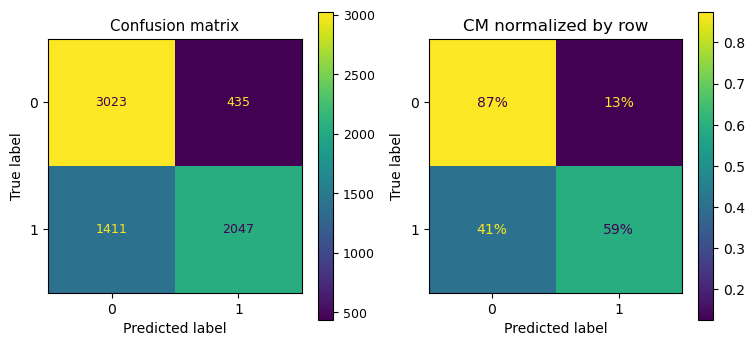

<Figure size 640x480 with 0 Axes>

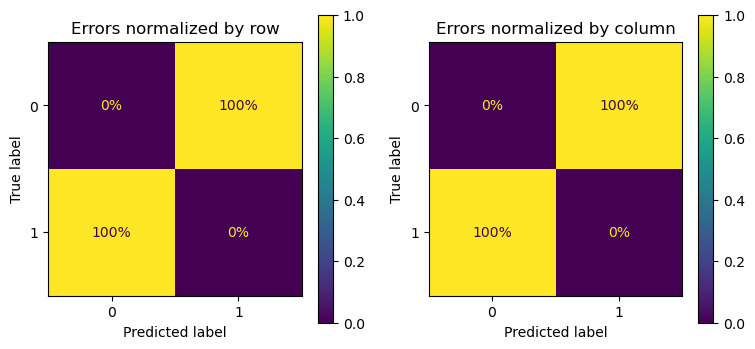

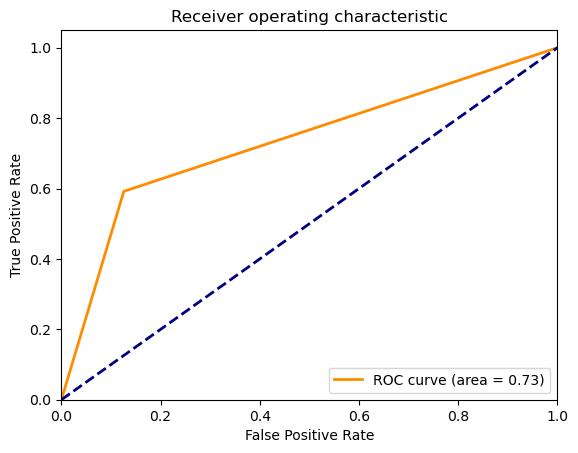

In [15]:
# Load the autoencoder model
autoencoder = load_model('autoencoder.h5')

# Function to calculate reconstruction error
def calculate_reconstruction_error(X, model):
    predictions = model.predict(X)
    errors = np.mean(np.power(X - predictions, 2), axis=1)
    return errors

# Function to convert reconstruction errors into class predictions
def errors_to_class(errors, threshold):
    classes = [1 if error > threshold else 0 for error in errors]
    return classes


start_time1 = time.time()
# Calculate reconstruction error for the test dataset
reconstruction_error_test = calculate_reconstruction_error(X_test, autoencoder)
end_time1 = time.time()
reconstruction_error_val_mixed = calculate_reconstruction_error(X_validation_mixed, autoencoder)

# Initialize the maximum accuracy to 0
max_accuracy = 0
best_threshold = 0

# Try thresholds between the minimum and the maximum validation reconstruction error
for threshold in np.linspace(np.min(reconstruction_error_val_mixed), np.max(reconstruction_error_val_mixed), 100):
    # Identify anomalies in the validation set
    anomalies_validation = errors_to_class(reconstruction_error_val_mixed, threshold)

    # Compute the validation accuracy
    accuracy_validation = accuracy_score(y_validation_mixed, anomalies_validation)

    # Update the maximum accuracy and the best threshold
    if accuracy_validation > max_accuracy:
        max_accuracy = accuracy_validation
        best_threshold = threshold

start_time2 = time.time()
# Get class predictions for the test set using the best threshold
y_pred = errors_to_class(reconstruction_error_test, best_threshold)
end_time2 = time.time()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
prediction_time = end_time1 - start_time1+end_time2-start_time2
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix and save it as PDF
sample_weight = (y_pred != y_test)

with PdfPages('Atuoencoder_Confusion_matrix_Princeton.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%", ax=axs[1])
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

# ROC Curve and save it as PDF
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
with PdfPages('autoencoder_roc_Princeton.pdf') as pdf:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    pdf.savefig(plt.gcf())  # Save the figure to PDF first
    plt.show()  # Then display the figure

plt.rc('font', size=14)  # make fonts great again


# Model Tuning

In [13]:
class AutoencoderHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_data = Input(shape=self.input_shape)
        
        encoded = Dense(units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32), 
                        activation=hp.Choice('dense_1_activation', values=['relu', 'tanh', 'sigmoid']), 
                        kernel_initializer='he_normal', 
                        kernel_regularizer=regularizers.l2(hp.Choice('dense_1_l2', values=[1e-2, 1e-3, 1e-4, 1e-5])))(input_data)
        encoded = Dropout(hp.Float('dropout_1', 0.0, 0.5, step=0.1, default=0.5))(encoded)
        encoded = BatchNormalization()(encoded)
        encoded = Reshape((-1, 1))(encoded)
        encoded = LSTM(units=hp.Int('lstm_1_units', min_value=32, max_value=256, step=32),
                       return_sequences=True, 
                       kernel_initializer='he_normal', 
                       kernel_regularizer=regularizers.l2(hp.Choice('lstm_1_l2', values=[1e-2, 1e-3, 1e-4, 1e-5])))(encoded)
        encoded = LSTM(units=hp.Int('lstm_2_units', min_value=32, max_value=256, step=32),
                       kernel_initializer='he_normal', 
                       kernel_regularizer=regularizers.l2(hp.Choice('lstm_2_l2', values=[1e-2, 1e-3, 1e-4, 1e-5])))(encoded)

        decoded = RepeatVector(self.input_shape[0])(encoded)
        decoded = LSTM(units=hp.Int('lstm_3_units', min_value=32, max_value=256, step=32),
                       return_sequences=True, 
                       kernel_initializer='he_normal', 
                       kernel_regularizer=regularizers.l2(hp.Choice('lstm_3_l2', values=[1e-2, 1e-3, 1e-4, 1e-5])))(decoded)
        decoded = LSTM(units=hp.Int('lstm_4_units', min_value=32, max_value=256, step=32),
                       return_sequences=True, 
                       kernel_initializer='he_normal', 
                       kernel_regularizer=regularizers.l2(hp.Choice('lstm_4_l2', values=[1e-2, 1e-3, 1e-4, 1e-5])))(decoded)
        decoded = TimeDistributed(Dense(1, kernel_initializer='he_normal',
                                        kernel_regularizer=regularizers.l2(hp.Choice('dense_2_l2', values=[1e-2, 1e-3, 1e-4, 1e-5]))))(decoded)
        decoded = Flatten()(decoded)
        decoded = Dense(self.input_shape[0], activation='sigmoid', kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(hp.Choice('dense_3_l2', values=[1e-2, 1e-3, 1e-4, 1e-5])))(decoded)

        model = Model(inputs=input_data, outputs=decoded)
        model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error')

        return model

input_shape = (26,)
hypermodel = AutoencoderHyperModel(input_shape)

tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='autoencoder_tuning',
    project_name='autoencoder',
    overwrite=True  # Overwrite the existing project
)


tuner.search_space_summary()

stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Saving the best model to a file
checkpoint = ModelCheckpoint('autoencoder_best.h5', save_best_only=True)

# Logging the training process to a csv file
csv_logger = CSVLogger('training_log.csv')

tuner.search(X_train, X_train,
             epochs=100,
             validation_data=(X_validation_mixed, X_validation_mixed),
             callbacks=[stop_early, checkpoint, csv_logger],
             verbose=1)  # 1 or 2 for more detailed information

tuner.results_summary()

# Getting the best model from tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
best_model.summary()

# Saving the best model explicitly
best_model.save('autoencoder_best_from_tuner.h5')

# To load the best model from file
loaded_model = load_model('autoencoder_best.h5')

# To read the training logs
logs = pd.read_csv('training_log.csv')
print(logs)


In [22]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Load the training log
# logs = pd.read_csv('training_log.csv')

# # Plotting the training and validation loss
# plt.figure(figsize=(12, 6))
# plt.plot(logs['epoch'], logs['loss'], label='Training Loss')
# plt.plot(logs['epoch'], logs['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Time')
# plt.legend()

# # Save the plot as an image file
# plt.savefig('training_validation_loss.png')

In [16]:
best_model = load_model('autoencoder_best_from_tuner.h5')
# best_model = load_model('autoencoder_best.h5')


# Function to calculate reconstruction error
def calculate_reconstruction_error(X, model):
    predictions = model.predict(X)
    errors = np.mean(np.power(X - predictions, 2), axis=1)
    return errors

# Function to convert reconstruction errors into class predictions
def errors_to_class(errors, threshold):
    classes = [1 if error > threshold else 0 for error in errors]
    return classes


start_time1 = time.time()
# Calculate reconstruction error for the test dataset
reconstruction_error_test = calculate_reconstruction_error(X_test, best_model)
end_time1 = time.time()
reconstruction_error_val_mixed = calculate_reconstruction_error(X_validation_mixed, best_model)

# Initialize the maximum accuracy to 0
max_accuracy = 0
best_threshold = 0

# Try thresholds between the minimum and the maximum validation reconstruction error
for threshold in np.linspace(np.min(reconstruction_error_val_mixed), np.max(reconstruction_error_val_mixed), 100):
    # Identify anomalies in the validation set
    anomalies_validation = errors_to_class(reconstruction_error_val_mixed, threshold)

    # Compute the validation accuracy
    accuracy_validation = accuracy_score(y_validation_mixed, anomalies_validation)

    # Update the maximum accuracy and the best threshold
    if accuracy_validation > max_accuracy:
        max_accuracy = accuracy_validation
        best_threshold = threshold

start_time2 = time.time()
# Get class predictions for the test set using the best threshold
y_pred = errors_to_class(reconstruction_error_test, best_threshold)
end_time2 = time.time()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
prediction_time = end_time1 - start_time1+end_time2-start_time2
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix and save it as PDF
sample_weight = (y_pred != y_test)

with PdfPages('Atuoencoder_Confusion_matrix_tuned_Princeton.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%", ax=axs[1])
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page


# ROC Curve and save it as PDF
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
with PdfPages('autoencoder_roc_tuned_Princeton.pdf') as pdf:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    pdf.savefig(plt.gcf())  # Save the figure to PDF first
    plt.show()  # Then display the figure

plt.rc('font', size=14)  # make fonts great again